In [1]:
import pickle
import time
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
lr = 0.001
batch_size = 4096
iterations = 20001
print_every = 2000 
hidden_dim = 512
load_checkpoint = 1999
# Model class
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)


# reinit lora utils, loraGA
from tqdm import tqdm
from peft.tuners.lora import LoraLayer
@torch.no_grad()
def reinit_lora_modules(name, module, gamma, named_grad):
    r"""
    Reinitialize the lora model with the given configuration.
    """
    lora_r = min(module.lora_A.default.weight.shape)


    print("*************************")
    
    # grad_name = name + '.weight'
    grad_name = ".".join(name.split(".")[-2:]) + '.weight'
    print(grad_name)
    grads = named_grad[grad_name]

    m, n = grads.shape
    print(m,n)
    U, S, V = torch.linalg.svd(grads.float())
    B = U[:, lora_r : 2 * lora_r]
    A = V[:lora_r, :]
    m, n = grads.shape # m: feature_out, n: feature_in
    # the scale of output is only related to the feature_out
    gamma = 9
    B = B * m**0.25 / gamma**0.5
    A = A * m**0.25 / gamma**0.5

    module.lora_B.default.weight = torch.nn.Parameter(B.contiguous().cuda())
    module.lora_A.default.weight = torch.nn.Parameter(A.contiguous().cuda())
    return
def reinit_lora(model, gamma, named_grad):
    r"""
    Reinitialize the lora model with the given configuration.
    """
    inited_modules = []
    for name, module in tqdm(
        model.named_modules(),
        desc="Reinitializing Lora",
        total=len(list(model.named_modules())),
    ):
        
        if isinstance(module, LoraLayer):
            reinit_lora_modules(name, module, gamma, named_grad)

    pass
    return model



Using gpu


## Theorem 3.1

In [3]:
from peft import LoraConfig, get_peft_model
# checkpoint_steps = [1999,7999,13999,19999]
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
    init_lora_weights="gaussian",
)
vf = get_peft_model(vf, lora_config)
print(vf.state_dict()['base_model.model.main.8.lora_A.default.weight'].shape)

gamma = 9
with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step0.pkl', 'rb') as f:
    named_grad = pickle.load(f)
_ = reinit_lora(vf, gamma, named_grad)

# print(vf.state_dict().keys())
state_dict = vf.state_dict()
layer_num  = [0, 2, 4, 6, 8]
def w1distance(matrix1, matrix2):
    """
    Calculate the Wasserstein distance between two matrices.
    """
    # Flatten the matrices to 1D arrays
    flat_matrix1 = matrix1.flatten()
    flat_matrix2 = matrix2.flatten()
    
    # Calculate the Wasserstein distance
    distance = wasserstein_distance(flat_matrix1.cpu().numpy(), flat_matrix2.cpu().numpy())
    
    return distance

def fro_norm(matrix1, matrix2):
    """
    Calculate the Frobenius norm between two matrices.
    """
    # Flatten the matrices to 1D arrays
    flat_matrix1 = matrix1.flatten()
    flat_matrix2 = matrix2.flatten()
    
    flat_matrix1 = flat_matrix1.to(device)
    flat_matrix2 = flat_matrix2.to(device)
    # Calculate the Frobenius norm
    norm = torch.norm(flat_matrix1 - flat_matrix2, p='fro')
    
    return norm.item()

for i in range(5):
    ref_distance1 = []
    ref_distance2 = []
    loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
    loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']

    raw_gradient = named_grad[f'main.{layer_num[i]}.weight']
    lora_combined_weights = loraB_weights @ loraA_weights
    distance1 = w1distance(lora_combined_weights, raw_gradient)
    distance2 = fro_norm(lora_combined_weights, raw_gradient)
    for j in range(100):
        random_loraB_weights = torch.randn_like(loraB_weights)
        random_loraA_weights = torch.randn_like(loraA_weights)
        random_combined_weights = random_loraB_weights @ random_loraA_weights
        random_distance1 = w1distance(random_combined_weights, raw_gradient)
        random_distance2 = fro_norm(random_combined_weights, raw_gradient)
        ref_distance1.append(random_distance1)
        ref_distance2.append(random_distance2)

    ref_distance1 = np.array(ref_distance1)
    ref_distance2 = np.array(ref_distance2)
    print(f"Layer {i}: Wasserstein Distance = {distance1}, Frobenius Norm = {distance2}")
    print(f"Layer {i}: Wasserstein Distance (random) = {ref_distance1.mean()}, Frobenius Norm (random) = {ref_distance2.mean()}")





torch.Size([8, 512])


Reinitializing Lora:   0%|          | 0/63 [00:00<?, ?it/s]

*************************
main.0.weight
512 3


Reinitializing Lora:   8%|▊         | 5/63 [00:10<02:06,  2.18s/it]

*************************
main.2.weight
512 512


Reinitializing Lora:  27%|██▋       | 17/63 [00:11<00:25,  1.80it/s]

*************************
main.4.weight
512 512


Reinitializing Lora:  46%|████▌     | 29/63 [00:13<00:10,  3.10it/s]

*************************
main.6.weight
512 512


Reinitializing Lora:  65%|██████▌   | 41/63 [00:14<00:04,  4.43it/s]

*************************
main.8.weight
2 512


Reinitializing Lora: 100%|██████████| 63/63 [02:03<00:00,  1.96s/it]


Layer 0: Wasserstein Distance = 0.011604597231894156, Frobenius Norm = 4.354754447937012
Layer 0: Wasserstein Distance (random) = 1.2466558703306834, Frobenius Norm (random) = 64.74647312164306


KeyboardInterrupt: 

## Theorem 3.2

## Boss Ordered


torch.Size([8, 512])


Reinitializing Lora:   0%|          | 0/63 [00:00<?, ?it/s]

Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 746.19it/s]

*************************
main.0.weight
512 3
*************************
main.2.weight
512 512
*************************
main.4.weight
512 512
*************************
main.6.weight
512 512
*************************
main.8.weight
2 512
Step: 399, Module: main.0.weight, LR: 1e-05, Distance: 91.43632507324219
Step: 399, Module: main.0.weight, LR: 0.0001, Distance: 91.43635559082031
Step: 399, Module: main.0.weight, LR: 0.001, Distance: 91.43663024902344
Step: 399, Module: main.0.weight, LR: 0.01, Distance: 91.43944549560547
Step: 399, Module: main.0.weight, LR: 0.1, Distance: 91.46682739257812
Step: 399, Module: main.0.weight, LR: 1, Distance: 91.65872955322266
Step: 399, Module: main.0.weight, LR: 10, Distance: 91.34679412841797
Step: 399, Module: main.0.weight, LR: 20, Distance: 91.1841812133789
Step: 399, Module: main.2.weight, LR: 1e-05, Distance: 89.7638931274414
Step: 399, Module: main.2.weight, LR: 0.0001, Distance: 89.76387786865234
Step: 399, Module: main.2.weight, LR: 0.001, Di

Step: 799, Module: main.4.weight, LR: 1e-05, Distance: 89.9830322265625
Step: 799, Module: main.4.weight, LR: 0.0001, Distance: 89.9830322265625
Step: 799, Module: main.4.weight, LR: 0.001, Distance: 89.9830093383789
Step: 799, Module: main.4.weight, LR: 0.01, Distance: 89.98280334472656
Step: 799, Module: main.4.weight, LR: 0.1, Distance: 89.9807357788086
Step: 799, Module: main.4.weight, LR: 1, Distance: 89.96465301513672
Step: 799, Module: main.4.weight, LR: 10, Distance: 89.95489501953125
Step: 799, Module: main.4.weight, LR: 20, Distance: 89.95588684082031
Step: 799, Module: main.6.weight, LR: 1e-05, Distance: 90.19342803955078
Step: 799, Module: main.6.weight, LR: 0.0001, Distance: 90.19342041015625
Step: 799, Module: main.6.weight, LR: 0.001, Distance: 90.19331359863281
Step: 799, Module: main.6.weight, LR: 0.01, Distance: 90.19215393066406
Step: 799, Module: main.6.weight, LR: 0.1, Distance: 90.18040466308594
Step: 799, Module: main.6.weight, LR: 1, Distance: 90.0577392578125
S

KeyError: (399, 'main.8.weight', 1)

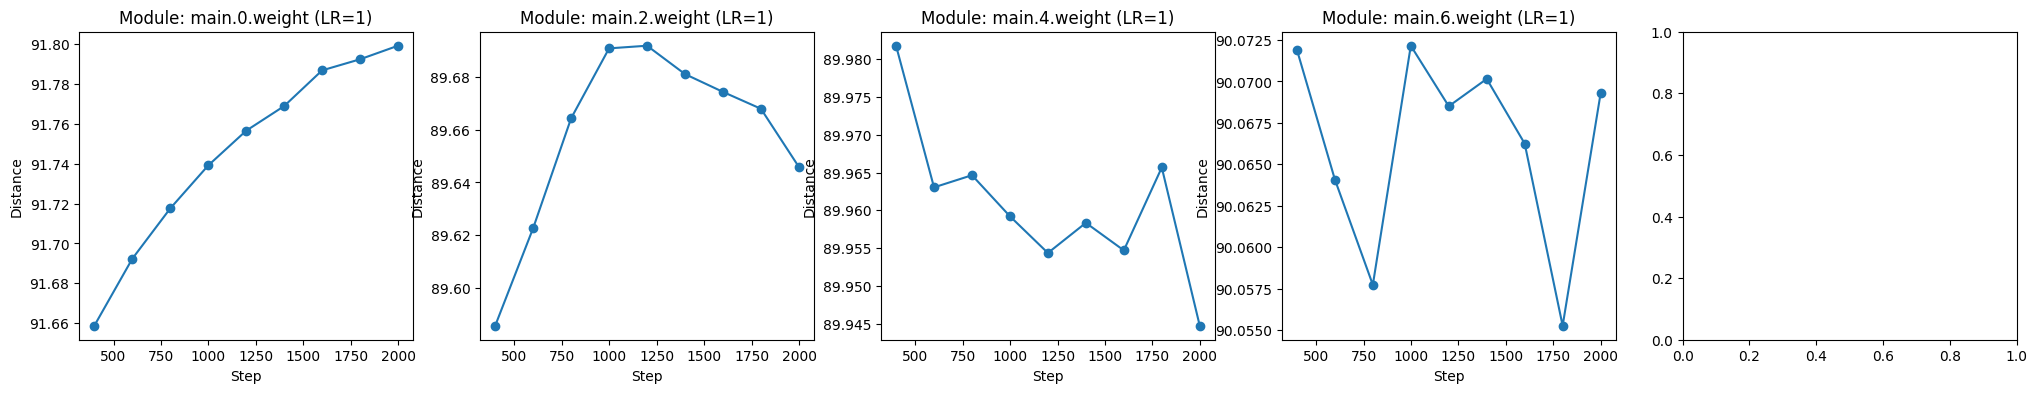

In [6]:
from peft import LoraConfig, get_peft_model
# checkpoint_steps = [1999,7999,13999,19999]
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
    init_lora_weights="gaussian",
)
vf = get_peft_model(vf, lora_config)
print(vf.state_dict()['base_model.model.main.8.lora_A.default.weight'].shape)

gamma = 9
with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step0.pkl', 'rb') as f:
    named_grad = pickle.load(f)
_ = reinit_lora(vf, gamma, named_grad)

# print(vf.state_dict().keys())
state_dict = vf.state_dict()
layer_num  = [0, 2, 4, 6, 8]

load_checkpoint = 0
checkpoint_steps = [199 + i * 200 for i in range(1, 10)]
with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step{load_checkpoint}.pkl', 'rb') as f:
    raw_models_grads = pickle.load(f)

module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                   "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                   "main.8.weight", "main.8.bias"]
# checkpoint_steps = [1999,7999,13999,19999]
vf1 = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
if load_checkpoint!= 0:
    state_dict_path = f'/home/u5649209/workspace/flow_matching/ckpts/raw_models/raw_model_{load_checkpoint}.pth'
    state_dict = torch.load(state_dict_path, map_location=device)
    vf1.load_state_dict(state_dict)
distance_module_dict = {}
# Calculate distance between original weights + lora_weights & trained weights
for ckpt in checkpoint_steps:

    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/raw_models/raw_model_{ckpt}.pth'
    
    original_weights = vf1.state_dict()
    loaded_weights = torch.load(weight_path, map_location=device)
    
    learning_rate_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20]
    
    for i in range(4):
        module = f'main.{layer_num[i]}.weight'
        if 'bias' in module:
            continue
        weights = loaded_weights[module].to(device)
        gradients = raw_models_grads[module].to(device)
        for lr in learning_rate_list:
            # Reset model weights
            ori_module_weights= original_weights[module].to(device)
            loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
            loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']

            lora_combined_weights = loraB_weights @ loraA_weights

            after_optimization_weights = ori_module_weights + lr * lora_combined_weights
            # distance = torch.norm(after_optimization_weights - weights).item()
            # distance = wasserstein_distance(after_optimization_weights.cpu().numpy().flatten(), weights.cpu().numpy().flatten())
            dot_product = np.dot(after_optimization_weights.flatten().cpu().numpy(), weights.flatten().cpu().numpy())
            norm_after = np.linalg.norm(after_optimization_weights.flatten().cpu().numpy())
            norm_weights = np.linalg.norm(weights.flatten().cpu().numpy())
            distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180
            # Print the step, module, learning rate, and distance
            # print(f"Step: {step}, Module: {module}, LR: {lr}, Distance: {distance}")
            print(f"Step: {ckpt}, Module: {module}, LR: {lr}, Distance: {distance}")
            distance_module_dict[(ckpt, module, lr)] = distance

# Plot distance vs step for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]
for idx, module in enumerate(modules):
    steps = checkpoint_steps
    distances = [distance_module_dict[(step, module, lr_fixed)] for step in steps]
    axs[idx].plot(steps, distances, marker='o')
    axs[idx].set_xlabel("Step")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")
print(distance_module_dict[(1999, 'main.0.weight', 1)])
plt.tight_layout()
plt.savefig("distance_vs_step_lr1.png")
plt.show()

In [ ]:
from peft import LoraConfig, get_peft_model
# checkpoint_steps = [1999,7999,13999,19999]
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
    init_lora_weights="gaussian",
)
vf = get_peft_model(vf, lora_config)
print(vf.state_dict()['base_model.model.main.8.lora_A.default.weight'].shape)

gamma = 9
with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step0.pkl', 'rb') as f:
    named_grad = pickle.load(f)
_ = reinit_lora(vf, gamma, named_grad)

# print(vf.state_dict().keys())
state_dict = vf.state_dict()
layer_num  = [0, 2, 4, 6, 8]

load_checkpoint = 0
checkpoint_steps = [199 + i * 200 for i in range(1, 10)]
with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step{load_checkpoint}.pkl', 'rb') as f:
    raw_models_grads = pickle.load(f)

module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                   "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                   "main.8.weight", "main.8.bias"]
# checkpoint_steps = [1999,7999,13999,19999]
vf1 = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
if load_checkpoint!= 0:
    state_dict_path = f'/home/u5649209/workspace/flow_matching/ckpts/raw_models/raw_model_{load_checkpoint}.pth'
    state_dict = torch.load(state_dict_path, map_location=device)
    vf1.load_state_dict(state_dict)
distance_module_dict = {}
# Calculate distance between original weights + lora_weights & trained weights
for ckpt in checkpoint_steps:

    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/raw_models/raw_model_{ckpt}.pth'
    
    original_weights = vf1.state_dict()
    loaded_weights = torch.load(weight_path, map_location=device)
    
    learning_rate_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20]
    
    for i in range(4):
        module = f'main.{layer_num[i]}.weight'
        if 'bias' in module:
            continue
        weights = loaded_weights[module].to(device)
        gradients = raw_models_grads[module].to(device)
        for lr in learning_rate_list:
            # Reset model weights
            ori_module_weights= original_weights[module].to(device)
            loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
            loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']

            lora_combined_weights = loraB_weights @ loraA_weights

            after_optimization_weights = ori_module_weights + lr * lora_combined_weights
            # distance = torch.norm(after_optimization_weights - weights).item()
            # distance = wasserstein_distance(after_optimization_weights.cpu().numpy().flatten(), weights.cpu().numpy().flatten())
            dot_product = np.dot(after_optimization_weights.flatten().cpu().numpy(), weights.flatten().cpu().numpy())
            norm_after = np.linalg.norm(after_optimization_weights.flatten().cpu().numpy())
            norm_weights = np.linalg.norm(weights.flatten().cpu().numpy())
            distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180
            # Print the step, module, learning rate, and distance
            # print(f"Step: {step}, Module: {module}, LR: {lr}, Distance: {distance}")
            print(f"Step: {ckpt}, Module: {module}, LR: {lr}, Distance: {distance}")
            distance_module_dict[(ckpt, module, lr)] = distance

# Plot distance vs step for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]
for idx, module in enumerate(modules):
    steps = checkpoint_steps
    distances = [distance_module_dict[(step, module, lr_fixed)] for step in steps]
    axs[idx].plot(steps, distances, marker='o')
    axs[idx].set_xlabel("Step")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")
print(distance_module_dict[(1999, 'main.0.weight', 1)])
plt.tight_layout()
plt.savefig("distance_vs_step_lr1.png")
plt.show()